<a href="https://colab.research.google.com/github/mihalyimark/birdclef-2023/blob/main/birdclef_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
#Place kaggle.json in the /content folder before running

In [4]:
!chmod 600 /content/kaggle.json

In [5]:
#Download data
!kaggle competitions download -c birdclef-2023

100% 4.90G/4.91G [00:57<00:00, 126MB/s]
100% 4.91G/4.91G [00:57<00:00, 92.4MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [7]:
train_metadata = pd.read_csv('/content/train_metadata.csv', low_memory=False)
train_metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [8]:
train_metadata.nunique()

primary_label         264
secondary_labels      751
type                  796
latitude             6252
longitude            6301
scientific_name       264
common_name           264
author               1082
license                 4
rating                 11
url                 16941
filename            16941
dtype: int64

<Axes: ylabel='Frequency'>

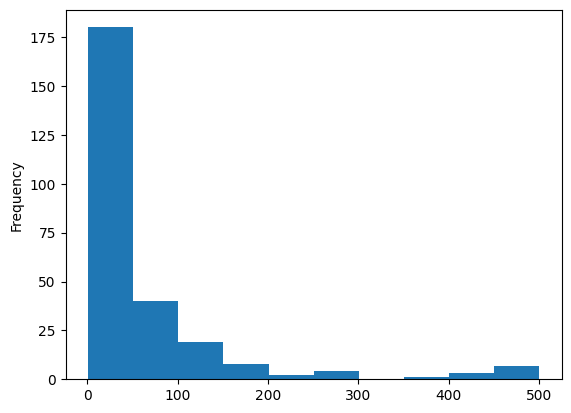

In [9]:
#Plot the histogram of frequencies of labels
train_metadata['common_name'].value_counts().plot.hist()

In [10]:
path = '/content/train_audio/'

In [11]:
#Collect duration information
duration = []
for i in tqdm(range(len(train_metadata))):
    audio_name = train_metadata['filename'][i]
    audio_path = os.path.join(path, audio_name)
    d = librosa.get_duration(path=audio_path)
    duration.append(d)

100%|██████████| 16941/16941 [00:33<00:00, 501.94it/s]


In [12]:
np.median(duration)

24.624

In [13]:
duration_series = pd.Series(duration)

<Axes: ylabel='Frequency'>

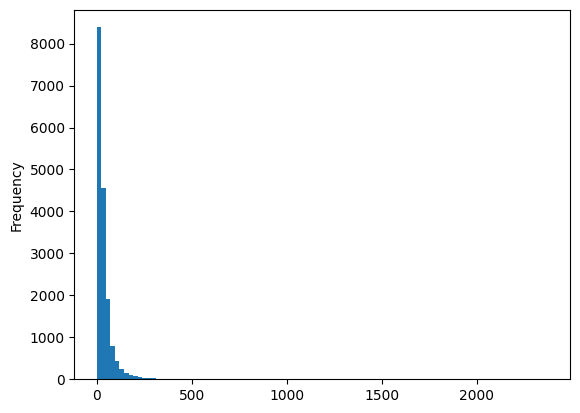

In [14]:
#Plot histogram of duration
duration_series.plot.hist(bins=100)

In [15]:
duration_series.describe()

count    16941.000000
mean        40.885565
std         69.610286
min          0.548000
25%         12.773875
50%         24.624000
75%         45.871031
max       2373.528000
dtype: float64

In [16]:
#Recordings indexes longer then 60 seconds
idxs_to_drop = []
for i in range(len(duration)):
    if duration[i] >= 60:
        idxs_to_drop.append(i)

In [17]:
len(idxs_to_drop)

2851

In [18]:
#Drop recordings longer then 60 seconds
train_metadata_filtered = train_metadata.drop(index=idxs_to_drop)

In [19]:
x = train_metadata_filtered['filename']

In [20]:
#One-hot encoding
y = pd.get_dummies(train_metadata_filtered['primary_label'], dtype=float)

In [21]:
#Train dataset
x_train, x_valid_test, y_train, y_valid_test = train_test_split(x, y, train_size=0.7, random_state=42)

In [22]:
#Validation and test dataset
x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size=0.33, random_state=42)

In [23]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [24]:
def split_audio(y, sr, duration=3):
    res = []
    # Calculate the number of samples for the desired duration
    samples_per_slice = int(duration * sr)

    # Calculate the total number of slices
    len_y = len(y)
    total_slices = int(np.ceil(len_y / samples_per_slice))

    # Split the audio into slices
    for i in range(total_slices):
        start_sample = i * samples_per_slice
        end_sample = min((i + 1) * samples_per_slice, len_y)

        # If sample is full, append to results
        if end_sample < len_y:
            audio_slice = y[start_sample:end_sample]
            res.append(audio_slice)

    return res

In [25]:
def make_mel(slices, sr):
    res = []
    for i in range(len(slices)):
        # Create the mel spectrogram
        melsgram = librosa.feature.melspectrogram(y=slices[i], sr=sr)
        mel_sgram_db = librosa.power_to_db(melsgram, ref=np.max)
        # It has to be 3 dimensional with 3 channels for Xception
        tensor_expanded = tf.expand_dims(mel_sgram_db, axis=-1)
        result = tf.tile(tensor_expanded, multiples=[1, 1, 3])
        res.append(result)

    return res

In [26]:
def shuffle_generator(audio, label, path, seed):
    idx = np.arange(len(audio))
    np.random.default_rng(seed).shuffle(idx)
    for i in idx:
        audio_path = os.path.join(path, audio[i])
        y, sr = librosa.load(audio_path)
        slices = split_audio(y, sr)
        images = make_mel(slices, sr)
        idx_image = np.arange(len(images))
        np.random.default_rng(seed).shuffle(idx_image)
        for j in idx_image:
            yield images[j], label[i]

In [27]:
input_shape = (128, 130, 3)
pred_shape = y_train.shape[1]
# Make the train, validation and test datasets from generators
dataset = tf.data.Dataset.from_generator(
    shuffle_generator,
    args=[x_train, y_train, path, 42],
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(pred_shape,), dtype=tf.float32))
)

val_dataset = tf.data.Dataset.from_generator(
    shuffle_generator,
    args=[x_valid, y_valid, path, 42],
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(pred_shape,), dtype=tf.float32))
)

test_dataset = tf.data.Dataset.from_generator(
    shuffle_generator,
    args=[x_test, y_test, path, 42],
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(pred_shape,), dtype=tf.float32))
)

# Use the keras dataset API for better performance (cache, batch, prefetch)
dataset = dataset.cache('/content/dataset').batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache('/content/val_dataset').batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [28]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=input_shape,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=input_shape)

# Pre-trained Xception weights requires that input be scaled
# from (-80, 0) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=-1 / 40.0, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x)  # Regularize with dropout
outputs = keras.layers.Dense(pred_shape, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 130, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 130, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 264)               540936 

In [29]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=Adam(learning_rate=3e-4),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [30]:
history = model.fit(dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    verbose=1)

Epoch 1/10
1113/1113 [==============================] - 2184s 2s/step - loss: 4.8461 - categorical_accuracy: 0.0825 - val_loss: 4.5455 - val_categorical_accuracy: 0.1225
Epoch 2/10
1113/1113 [==============================] - 113s 101ms/step - loss: 4.2416 - categorical_accuracy: 0.1412 - val_loss: 4.3920 - val_categorical_accuracy: 0.1404
Epoch 3/10
1113/1113 [==============================] - 116s 104ms/step - loss: 3.9964 - categorical_accuracy: 0.1701 - val_loss: 4.3170 - val_categorical_accuracy: 0.1540
Epoch 4/10
1113/1113 [==============================] - 117s 105ms/step - loss: 3.8254 - categorical_accuracy: 0.1906 - val_loss: 4.2705 - val_categorical_accuracy: 0.1631
Epoch 5/10
1113/1113 [==============================] - 133s 119ms/step - loss: 3.6963 - categorical_accuracy: 0.2076 - val_loss: 4.2450 - val_categorical_accuracy: 0.1679
Epoch 6/10
1113/1113 [==============================] - 117s 105ms/step - loss: 3.5934 - categorical_accuracy: 0.2252 - val_loss: 4.2260 - val

In [31]:
# Fine-tune the whole model
base_model.trainable = True
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 128, 130, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 128, 130, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 4, 4, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

In [32]:
# Set callbacks
early_stopping=EarlyStopping(patience=5, monitor='val_categorical_accuracy', verbose=1)
checkpointer=ModelCheckpoint(filepath='model.h5', monitor='val_categorical_accuracy', save_best_only=True, verbose=1)

In [33]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=Adam(learning_rate=3e-5),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [34]:
history = model.fit(dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=[early_stopping, checkpointer],
                    verbose=1)

Epoch 1/10
   1113/Unknown - 381s 318ms/step - loss: 2.9290 - categorical_accuracy: 0.3385
Epoch 1: val_categorical_accuracy improved from -inf to 0.29587, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1113/1113 [==============================] - 414s 347ms/step - loss: 2.9290 - categorical_accuracy: 0.3385 - val_loss: 3.5407 - val_categorical_accuracy: 0.2959
Epoch 2/10
1113/1113 [==============================] - ETA: 0s - loss: 2.3376 - categorical_accuracy: 0.4553
Epoch 2: val_categorical_accuracy improved from 0.29587 to 0.32621, saving model to model.h5
1113/1113 [==============================] - 383s 344ms/step - loss: 2.3376 - categorical_accuracy: 0.4553 - val_loss: 3.5313 - val_categorical_accuracy: 0.3262
Epoch 3/10
1113/1113 [==============================] - ETA: 0s - loss: 1.9562 - categorical_accuracy: 0.5346
Epoch 3: val_categorical_accuracy improved from 0.32621 to 0.34162, saving model to model.h5
1113/1113 [==============================] - 383s 344ms/step - loss: 1.9562 - categorical_accuracy: 0.5346 - val_loss: 3.5830 - val_categorical_accuracy: 0.3416
Epoch 4/10
1113/1113 [==============================] - ETA: 0s - loss: 1.6425 - categorical_accuracy: 0.6037
E

In [35]:
# Run best model on test dataset
model = load_model('model.h5')
test_err = model.evaluate(test_dataset)

156/156 [==============================] - 214s 1s/step - loss: 5.2521 - categorical_accuracy: 0.3920
